# Neural Network Final Model - Ragged Point, Barbados

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'RPB', 'This script is only for Ragged Point, Barbados. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Ragged Point, Barbados.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
2724,2001-03-05 05:00:00,1.0,-6.891492,-4.532814,-1.415217,-5.737577,-5.273374,-3.687269,-3.669378,-8.723823,...,-0.825777,-0.715919,-1.900854,-7.199176,-1.710106,-0.927983,-4.125887,-2.794475,2.806641,3.395282
27650,2019-07-07 15:00:00,0.0,-5.350700,-7.426046,-6.456365,-7.021014,-4.798678,-2.248691,-3.898606,-6.190552,...,-2.260818,0.844528,-3.036814,-2.595979,0.495761,-3.874944,0.802350,4.197503,0.523880,4.692308
26596,2018-11-27 13:00:00,1.0,-7.563882,-4.603339,-4.596664,-6.722410,-8.526625,-3.126219,-5.402163,-7.705920,...,0.922969,0.707887,-6.702654,-3.596462,-2.655752,1.158146,1.690419,-0.387618,3.822769,2.546943
2607,2001-02-20 05:00:00,1.0,-6.933391,-5.425624,-6.018405,-5.917457,-5.100655,-3.589661,-3.847793,-8.234190,...,-2.375072,-1.336238,-0.654527,0.624315,-3.476799,4.483975,4.431202,3.658402,-1.971683,-1.843004
19408,2012-12-02 15:00:00,1.0,-5.055728,-4.048021,-6.083662,-5.069887,-5.454199,-1.182671,-2.383748,-3.548011,...,-3.401959,-1.305843,1.088227,-6.583077,-2.794005,-3.399550,-1.354833,-5.210562,-1.189392,0.483485


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-02 05:00:00 -> 2018-12-31 23:00:00. Length: 1371
Val range: 2019-01-01 01:00:00 -> 2019-12-31 13:00:00. Length: 1213
Test range: 2020-01-01 17:00:00 -> 2022-12-30 19:00:00. Length: 3634


### Model

In [21]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(200,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.15, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.879
Precision on Validation Set = 0.846
Recall on Training Set = 0.914
Recall on Validation Set = 0.957
F1 Score on Training Set = 0.896
F1 Score on Validation Set = 0.898


In [22]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.845
Recall on Testing Set = 0.929
F1 Score on Testing Set = 0.885


In [23]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_RPB.joblib']

### Assessing Feature Importance

In [24]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

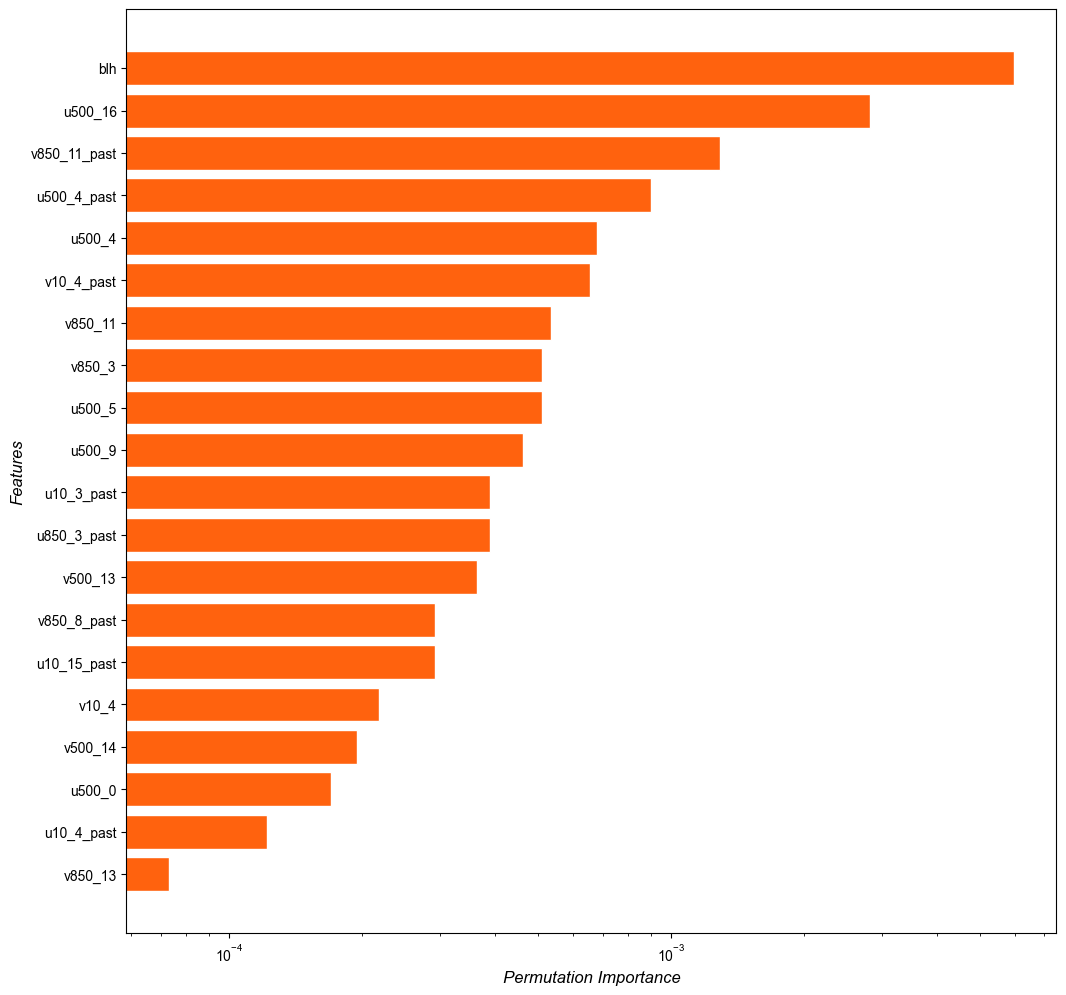

In [25]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features', fontsize=12, fontstyle='italic')
ax.set_xlabel('Permutation Importance', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importance (Testing Set)', fontsize=14)